<a name="top" id="top"></a>

<div align="center">
    <h1>Entropy Computing via QCi</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="https://github.com/AlbertLee125">Albert Lee</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Graduate Research Assistant</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/AlbertLee125/QUBONotebooks/blob/main/notebooks_py/6-QCi_python.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

## Entropy Computing via QCi
This notebook provides an introduction to solving constrained optimization problems using **Quantum Computing Inc.'s (QCI) Entropy Quantum Computer**.
We will define a **Constrained Quadratic Model** by setting up an objective function and a series of linear constraints. The notebook demonstrates how to:
1.  Structure the problem using QCI's `eqc_models` library.
2.  Submit the model to the `Dirac3IntegerCloudSolver` and `Dirac3ContinuousSolver` for processing.
3.  Analyze the high-quality candidate solutions returned by the solver to find the optimal result.



In [1]:
# If using this on Google colab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install eqc_models pyomo scip

In [2]:
# Import the QCI models and solvers
import eqc_models
from eqc_models.base import ConstrainedPolynomialModel, PolynomialModel, QuadraticModel
from eqc_models.solvers import Dirac3IntegerCloudSolver, Dirac3ContinuousCloudSolver

# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import pyomo.environ as pyo

### How Dirac-3 Works
The **Dirac-3** solver is a cloud-based quantum solver that uses the **Entropy Quantum Computer** (EQC) to solve optimization problems.
It encodes a problem into the physical properties of coherent light pulses, allowing it to represent and explore many potential solutions at once within its optical circuits. 
A controlled feedback loop, managed by electronics, interacts with the light to steer the system away from poor solutions. 
This process rapidly converges the system onto the single, lowest-energy state, which represents the optimal answer.

In [ ]:
# Define the API URL and token for QCI
# Note: Replace the api_url and api_token with your actual QCI API URL and token
api_url = "https://api.qci-prod.com" 
api_token = ""

### Solving Problems using Dirac-3

Dirac-3 can solve combinatorial optimization problems using the follwing objective function, `E`, that has the following high-order polynomial structure:

\begin{equation*}
E = \sum_{i=1}^{N} C_i V_i + \sum_{i,j=1}^{N,N} J_{ij} V_i V_j + \sum_{i,j,k=1}^{N,N,N} T_{ijk} V_i V_j V_k + \sum_{i,j,k,l=1}^{N,N,N,N} Q_{ijkl} V_i V_j V_k V_l + \sum_{i,j,k,l,m=1}^{N,N,N,N,N} P_{ijklm} V_i V_j V_k V_l V_m 
\end{equation*}

$V_i$ refers to the value of nonnegative variable, and $C_i$, $J_{ij}$, $T_{ijk}$, $Q_{ijkl}$, and $P_{ijklm}$ are the coefficients of the objective function.
The solver defaults to minimization. 
To solve a maximization problem, you should multiply the entire objective function by -1.

### Continuous Solver

The Dirac-3 continuous solver is particularly well-suited for this objective function, treating it as a **quasi-continuous optimization problem**.
In this approach, the solver operates under the linear constraint

\begin{equation*}
R = \sum_{i=1}^{N} V_i, \quad R \in [1, 10000].
\end{equation*}

Note that $R$ is a fixed value, which for this problem must be in the range of [1, 10000].

Let's try to solve the following simple quadratic problem with linear constraints using the Dirac-3 continuous solver:

\begin{align*}
\min \quad & E = 3 x_1^2 + 2 x_2^2 + x_3^2 \\
\text{s.t.} \quad & x_1 + x_2 + x_3 = 10, \\
& x_1, x_2, x_3 \in [0, 10].
\end{align*}

In [4]:
# 1. Create a concrete Pyomo model
m = pyo.ConcreteModel(name="Simple_Quadratic_Program")

# 2. Define the decision variables with their bounds
# The variables x_1, x_2, and x_3 are defined with bounds [0, 10].
m.x = pyo.Var([1, 2, 3], domain=pyo.NonNegativeReals, bounds=(0, 10))

# 3. Define the objective function
# The objective is to minimize the quadratic expression.
m.obj = pyo.Objective(
    expr=3*m.x[1]**2 + 2*m.x[2]**2 + m.x[3]**2, 
    sense=pyo.minimize
)

# 4. Define the linear constraint
# The sum of the variables must equal 10.
m.c1 = pyo.Constraint(expr=m.x[1] + m.x[2] + m.x[3] == 10)

# 5. Create a solver instance and solve the model
# We specify 'scip' as the solver. 'tee=True' displays the solver's log.
solver = pyo.SolverFactory('scip')
results = solver.solve(m, tee=False)

# 6. Display the optimization results
print("\n" + "="*30)
print("-- 📊 Optimization Results --")
print(f"Solver Status: {results.solver.status}")
print(f"Termination Condition: {results.solver.termination_condition}")
print(f"Objective Value (E): {pyo.value(m.obj):.4f}")
print("\n-- 🏗️ Variable Values --")
for i in m.x:
    print(f"x[{i}] = {pyo.value(m.x[i]):.4f}")
print("="*30)


-- 📊 Optimization Results --
Solver Status: ok
Termination Condition: optimal
Objective Value (E): 54.5455

-- 🏗️ Variable Values --
x[1] = 1.8183
x[2] = 2.7272
x[3] = 5.4545


#### Now let's solve this problem using the Dirac-3 continuous solver.
#### 1. Defining the Objective Function

The polynomial objective function, `E`, is defined by combining two lists: `coefficients` and `indices`.

* `coefficients`: This list contains the numerical multiplier for each term in your objective function.

    ```python
    coefficients = [3, 2, 1] 
    ```

* `indices`: This list of tuples specifies which variables are multiplied together for each term. The numbers in the tuples correspond to the variable indices (e.g., `1` for $x_1$, `2` for $x_2$).

    ```python
    # (1,1) -> x_1*x_1  |  (2,2) -> x_2*x_2  |  (3,3) -> x_3*x_3
    indices = [(1,1), (2,2), (3,3)]
    ```

The `PolynomialModel` maps the `coefficients` to the `indices` in order, creating the full objective function:

$E = \underbrace{3}_{\text{coef[0]}} \cdot \underbrace{x_1 x_1}_{\text{idx[0]}} + \underbrace{2}_{\text{coef[1]}} \cdot \underbrace{x_2 x_2}_{\text{idx[1]}} + \underbrace{1}_{\text{coef[2]}} \cdot \underbrace{x_3 x_3}_{\text{idx[2]}}$

### 2. Setting Constraints

Constraints are handled in two different places:

* **Variable Bounds** `upper_bound`: The individual upper bounds for each variable are set as an attribute on the `model` object *after* it has been created.

    ```python
    # Sets the upper bound for all 3 variables to 10
    model.upper_bound = 10 * np.ones((3,))
    ```

In [5]:
R = 10
coefficients = [3, 2, 1]
indices = [(1,1), (2,2), (3,3)] # Create a polynomial model
model = PolynomialModel(coefficients, indices)
model.upper_bound = R*np.ones((3,)) # Bounds for the variables

#### 3. Submitting the Model to the Solver
When submitting the model to the solver, you need to provide several key parameters:

* `sum_constraint`: The constraint on the sum of all variables ($R = \sum V_i$) is a **required input** for the `solver.solve()` method.
* `relaxation_schedule`: An integer from the set `{1, 2, 3, 4}` representing one of four predefined schedules. Higher values reduce variation in the analog spin values during the solving process and are more likely to result in a better objective function value.
* `num_samples`: An integer specifying the number of independent solutions (samples) to be generated by the device.

```python
# The solver needs the value for R, the schedule, and number of samples
response = solver.solve(
    model, 
    sum_constraint=10, 
    relaxation_schedule=1, 
    num_samples=10
)

In [6]:
solver = Dirac3ContinuousCloudSolver(url=api_url, api_token=api_token)
response = solver.solve(model, sum_constraint=10, relaxation_schedule=1, num_samples=20) # sum constraint is set to 10, 5 samples are collected

# Print the results
print(response["results"]["solutions"])
print(response["results"]["energies"])
print(response["results"]["counts"])

2025-07-14 16:20:42 - Dirac allocation balance = 9645 s (unmetered)
2025-07-14 16:20:42 - Job submitted: job_id='6875669932604586ad908760'
2025-07-14 16:20:42 - QUEUED
2025-07-14 16:20:45 - RUNNING
2025-07-14 16:20:48 - COMPLETED
2025-07-14 16:20:50 - Dirac allocation balance = 9645 s (unmetered)
[[1.7829233, 2.6768489, 5.5402284], [1.8972523, 2.6886857, 5.4140615], [1.8612562, 2.7916689, 5.347075], [1.8199943, 2.6266539, 5.5533524], [1.8612251, 2.8046658, 5.3341098], [1.7301159, 2.6964464, 5.5734372], [1.9174838, 2.6145248, 5.4679909], [1.6853371, 2.6967218, 5.6179419], [1.704867, 2.9283574, 5.3667746], [1.9487836, 2.8355696, 5.2156467], [1.9114457, 2.8855994, 5.2029543], [1.6616733, 2.6506038, 5.6877227], [1.9512023, 2.8418746, 5.206923], [1.9994645, 2.7611291, 5.2394061], [1.8984122, 2.9056239, 5.1959648], [1.6846387, 2.9427762, 5.3725858], [1.7045575, 2.5500438, 5.745399], [1.8729267, 2.958262, 5.1688118], [1.926976, 2.9246662, 5.1483583], [1.7908694, 3.0171177, 5.1920128]]
[54.561

#### 4. Interpreting the Results
The solver returns a dictionary containing job information and results. The optimal solution is found by identifying the result with the lowest "energy" (objective function value).
The `response['results']` key contains three important lists that correspond to each other by index:

* `solutions`: A list of all potential solutions. Each item is a list of variable values (e.g., `[x1, x2, x3]`).

* `energies`: A list of the objective function values (`energies`) for each corresponding solution.

* `counts`: A list of how many times each solution was found (typically 1 for unique solutions).

In [7]:
# Extract the results from the response
results = response["results"]
energies = results["energies"]
solutions = results["solutions"]

# Find the index of the best solution (minimum energy)
best_index = np.argmin(energies)

# Get the best solution and its energy
best_energy = energies[best_index]
best_solution = solutions[best_index]

# Print the results in a clear format
print("-- 📊 Best Solution Found --")
print(f"Optimal Objective (Energy): {best_energy:.4f}")
print(f"Variable Values: {np.round(best_solution, 4)}")


-- 📊 Best Solution Found --
Optimal Objective (Energy): 54.5616
Variable Values: [1.7829 2.6768 5.5402]


### Integer Solver
The Dirac-3 can solver unconstrained optimization problem. 
In this mode, the resulting state vector $V_i$ consists of integers:

\begin{equation*}
V_i \in \mathbb{N}, \quad 0 \leq V_i \leq 16
\end{equation*}

For integer problems, you must define the number of possible states (or levels) for each variable. 
For instance, to model a standard Qudratic Unconstrained Binary Optimization problem, you would set the number of levels for each variable to 2. 
This restricts the variables to two possible states, 0 and 1, which is equivalent to defining a binary variable with an upper bound of 1.

The solver is flexible, allowing for mixed encoding where some variables have 2 levels (binary) while others have more (up to 17 levels, for an upper bound of 16). 
If your problem requires more than 17 distinct states for any variable, the **continuous solver** is the recommended approach.

Let's solve the simple QUBO problem given by the following objective function:

\begin{align*}
\min \quad & E = -0.75 x_1^2 - 0.25 x_2^2 + 2 x_1 x_2 + 0.5 x_1 \\
\text{s.t.} \quad & x_1, x_2 \in \{0,1\} \\
\end{align*}

In [8]:
# 1. Create a concrete Pyomo model
m = pyo.ConcreteModel(name="Simple_QUBO")

# 2. Define the binary variables
# x[1] and x[2] can only take values of 0 or 1.
m.x = pyo.Var([1, 2], domain=pyo.Binary)

# 3. Define the objective function
# We use the property that for a binary variable x, x^2 = x.
# So, the objective E = -0.75*x1^2 - 0.25*x2^2 + 2*x1*x2 + 0.5*x1 becomes:
# E = -0.75*x1 - 0.25*x2 + 2*x1*x2
m.obj = pyo.Objective(
    expr= -0.75 * m.x[1] - 0.25 * m.x[2] + 2 * m.x[1] * m.x[2] + 0.5 * m.x[1],
    sense=pyo.minimize
)

# 4. Create a solver instance and solve the model
# This is an unconstrained problem, so no constraints are needed.
# We use a Mixed-Integer Programming (MIP) solver like 'scip'.
solver = pyo.SolverFactory('scip')
results = solver.solve(m, tee=False)

# 5. Display the optimization results
print("\n" + "="*30)
print("-- 📊 Optimization Results --")
print(f"Solver Status: {results.solver.status}")
print(f"Termination Condition: {results.solver.termination_condition}")
print(f"Objective Value: {pyo.value(m.obj):.4f}")
print("\n-- 🏗️ Variable Values --")
for i in m.x:
    print(f"x[{i}] = {int(pyo.value(m.x[i]))}")
print("="*30)


-- 📊 Optimization Results --
Solver Status: ok
Termination Condition: optimal
Objective Value: -0.2500

-- 🏗️ Variable Values --
x[1] = 1
x[2] = 0


#### Now let's solve this problem using the Dirac-3 Integer solver.
The problem's `coefficients` and `indices` are structured in the same way as they were for the continuous solver.

In [9]:
coefficients = [-0.75, -0.25, 2, 0.5]  # Coefficients for the polynomial model
indices = [(1, 1), (2, 2), (1, 2), (0, 1)]  # Create a polynomial model
model = PolynomialModel(coefficients, indices)

# add upper bounds for the variables
model.upper_bound = np.ones((2,))  # Bounds for the variables

For integer and binary optimization problems, the sum_constraint is not necessary because `Dirac3IntegerCloudSover` operates in an unconstrained mode.

In [10]:
solver = Dirac3IntegerCloudSolver(url=api_url, api_token=api_token)
response = solver.solve(model, relaxation_schedule=1, num_samples=10)

# Print the results
print(response)
print(response["results"]["solutions"])
print(response["results"]["energies"])
print(response["results"]["counts"])

2025-07-14 16:20:52 - Dirac allocation balance = 9645 s (unmetered)
2025-07-14 16:20:52 - Job submitted: job_id='687566a332604586ad908761'
2025-07-14 16:20:52 - QUEUED
2025-07-14 16:20:55 - RUNNING
2025-07-14 16:21:00 - COMPLETED
2025-07-14 16:21:03 - Dirac allocation balance = 9645 s (unmetered)
{'job_info': {'job_id': '687566a332604586ad908761', 'job_submission': {'problem_config': {'qudit_hamiltonian_optimization': {'polynomial_file_id': '687566a3acc178773e993158'}}, 'device_config': {'dirac-3_qudit': {'num_levels': [2, 2], 'num_samples': 10, 'relaxation_schedule': 1}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-07-14T20:20:51.723Z', 'queued_at_rfc3339nano': '2025-07-14T20:20:51.724Z', 'running_at_rfc3339nano': '2025-07-14T20:20:51.82Z', 'completed_at_rfc3339nano': '2025-07-14T20:20:57.055Z'}, 'job_result': {'file_id': '687566a9acc178773e99315a', 'device_usage_s': 4}}, 'status': 'COMPLETED', 'results': {'counts': [9, 1], 'energies': [-0.25, -0.25], 'solutions': [[0, 1], [1, 0

This code processes the solver's results by counting the frequency of each unique solution and then uses `matplotlib` to create a bar chart visualizing this distribution.

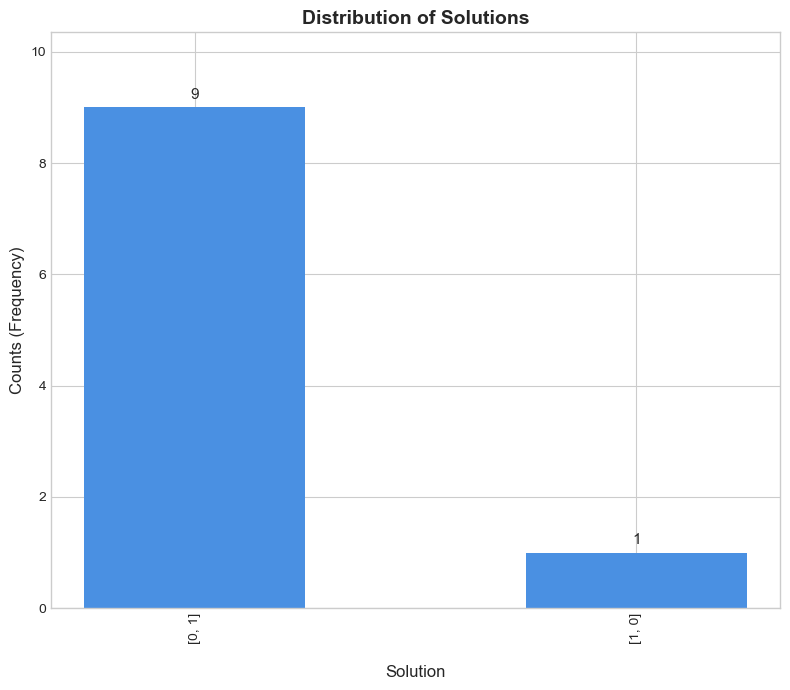

In [11]:
def plot_solution_distribution(response):
    """
    Processes a solver response and plots the distribution of unique solutions.

    Args:
        response (dict): The response dictionary from the Dirac-3 solver,
                         containing 'solutions' and 'counts' in its 'results' key.
    """
    # --- Data Processing ---
    # Extract the raw results from the response dictionary
    results = response.get('results', {})
    raw_solutions = results.get('solutions', [])
    raw_counts = results.get('counts', [])

    if not raw_solutions or not raw_counts:
        print("Response object does not contain valid solutions or counts.")
        return

    # Aggregate counts for each unique solution
    solution_counts = {}
    for solution, count in zip(raw_solutions, raw_counts):
        # Convert list to tuple to use it as a dictionary key
        solution_tuple = tuple(solution)
        solution_counts[solution_tuple] = solution_counts.get(solution_tuple, 0) + count

    # Prepare data for plotting
    # Create string labels for the x-axis from the solution tuples
    plot_solutions_str = [str(list(s)) for s in solution_counts.keys()]
    plot_counts = list(solution_counts.values())

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(8, 7)) # Increased height for rotated labels

    # Create the bar plot
    bars = ax.bar(plot_solutions_str, plot_counts, color='#4A90E2', width=0.5)

    # Add labels and title for clarity
    ax.set_xlabel("Solution", fontsize=12, labelpad=15)
    ax.set_ylabel("Counts (Frequency)", fontsize=12)
    ax.set_title("Distribution of Solutions", fontsize=14, fontweight='bold')
    
    # Rotate x-axis labels to prevent overlap
    plt.xticks(rotation=90)
    
    # Ensure the y-axis only displays integer values
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    # Add count labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, int(yval), ha='center', va='bottom', fontsize=11)

    # Set y-axis to start at 0 and give some space at the top
    if plot_counts:
        ax.set_ylim(0, max(plot_counts) * 1.15)

    # Adjust layout to make room for rotated labels
    plt.tight_layout()
    plt.show()

# Plot the distribution of unique solutions
plot_solution_distribution(response)

#### Solving Quadratic Unconstrained Binary Optimization (QUBO) Problems via Dirac-3 Integer Solver
A Quadratic Unconstrained Binary Optimization (QUBO) problem is defined by the goal of minimizing the following objective function, `E`, over a set of binary variables:
$$
\min_x \quad E(x)=\sum_i C_i x_i + \sum_{ij} J_{ij} x_i x_j + c_Q
$$

where the variables $x_i$ are binary, i.e., $x_i \in \{0,1\}$, where $C_i$ are the linear coefficients, $J_{ij}$ are the quadratic coefficients, and $c_Q$ is an offset term.
The Dirac-3 Integer Solver is specifically designed to solve problems of this nature. 
To submit a QUBO problem, you provide the `C` and `J` Hamiltonians to the `QuadraticModel`. 
The constant offset $c_Q$ is not passed to the model directly; instead, it should be stored separately and added to the final energy value returned by the solver to get the true objective function value.

#### Example
Suppose we want to solve the following linear integer problem via QUBO
$$
\min_{\mathbf{x}} 2𝑥_0+4𝑥_1+4𝑥_2+4𝑥_3+4𝑥_4+4𝑥_5+5𝑥_6+4𝑥_7+5𝑥_8+6𝑥_9+5𝑥_{10} \\
s.t. \begin{bmatrix}
1 & 0 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 1 & 1\\
0 & 1 & 0 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 1\\
0 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}\mathbf{x}=
\begin{bmatrix}
1\\
1\\
1
\end{bmatrix} \\
\mathbf{x} \in \{0,1 \}^{11}
$$


First we would write this problem as a an unconstrained one by penalizing the linear constraints as quadratics in the objective. Let's first define the problem parameters

In [12]:
A = np.array([[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
            [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
            [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]])
b = np.array([1, 1, 1])
c = np.array([2, 4, 4, 4, 4, 4, 5, 4, 5, 6, 5])
num_variables = A.shape[1]

Given the parameters, we can solve the problem using classical methods.
However, we can also use the `eqc_models` library to solve this problem using the Dirac-3 Integer solver.

In [13]:
# Build a Pyomo model for the constrained linear integer program
m = pyo.ConcreteModel(name="Constrained_Linear_Integer_Program")

# Define the set of variable indices
m.I = pyo.RangeSet(0, num_variables - 1)
# Define the set of constraint indices
m.J = pyo.RangeSet(0, A.shape[0] - 1)

# Define the 11 binary variables
m.x = pyo.Var(m.I, domain=pyo.Binary)

# Define the Objective Function
# The objective is the original linear expression.
m.obj = pyo.Objective(
    expr=sum(c[i] * m.x[i] for i in m.I),
    sense=pyo.minimize
)

# Define the constraints
# We define a set of constraints Ax = b directly.
def ax_constraint_rule(model, j):
    # For each row j, sum(A[j,i] * x[i]) must equal b[j]
    return sum(A[j, i] * model.x[i] for i in model.I) == b[j]

m.constraints = pyo.Constraint(m.J, rule=ax_constraint_rule)

# Solve the model
# We use a Mixed-Integer Linear Programming (MILP) solver.
solver = pyo.SolverFactory('scip')
results = solver.solve(m, tee=False)

# Display the optimization results
print("\n" + "="*40)
print("-- 📊 Optimization Results --")
print(f"Solver Status: {results.solver.status}")
print(f"Termination Condition: {results.solver.termination_condition}")
print(f"Objective Value: {pyo.value(m.obj):.4f}")

print("\n-- 🏗️ Variable Values --")
solution_vector = [int(pyo.value(m.x[i])) for i in m.I]
print(f"x = {solution_vector}")



-- 📊 Optimization Results --
Solver Status: ok
Termination Condition: optimal
Objective Value: 5.0000

-- 🏗️ Variable Values --
x = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In order to define the `C` and `J` matrix, we reformulate the linear problem
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x}\\
s.t. \mathbf{A}\mathbf{x}=\mathbf{b} \\
\mathbf{x} \in \{0,1 \}^{11}
$$
as follows:
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x} + \rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) \\
\mathbf{x} \in \{0,1 \}^{11}
$$
where $\rho$ is a penalization factor that ensures the constraints are satisfied. 

The term $\rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b})$ penalizes deviations from the constraints.
$$
\rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) = \rho( \mathbf{x}^\top (\mathbf{A}^\top \mathbf{A}) \mathbf{x} - 2\mathbf{b}^\top \mathbf{A} \mathbf{x} + \mathbf{b}^\top \mathbf{b} )
$$

From this reformulation, we can derive the quadratic hamiltonian, linear hamiltonian and offset as follows:
$$
C = \mathbf{c} - 2\rho\mathbf{A}^\top \mathbf{b}
$$

$$
J = \rho\mathbf{A}^\top \mathbf{A}
$$

$$
c_Q = \rho(\mathbf{b}^\top \mathbf{b})
$$

For this problem in particular, one can prove the the penalization factor is given by $\rho > \sum_{i=1}^n |c_i|$, therefore we choose this bound + 1.

In [14]:
epsilon = 1 # small value to avoid division by zero
rho = np.sum(np.abs(c)) + epsilon # penalty multiplier

# Construct the quadratic Hamiltonian J
J = rho*np.matmul(A.T,A)

# Construct the linear Hamiltonian C
C = c.copy()  
C -= rho*2*(np.matmul(b.T,A))

# Construct the offset term cQ
cQ = rho*np.matmul(b.T,b)

# --- Formatted Printing ---
print("\n" + "="*60)
print("--- QUBO Formulation Parameters ---")
# Set numpy print options for better readability
np.set_printoptions(precision=2, suppress=True)

print("\nQuadratic Hamiltonian (J):\n", J)
print("\n" + "-"*60)
print("\nLinear Hamiltonian (C):\n", C)
print("\n" + "-"*60)
print(f"\nOffset Term (cQ): {cQ:.2f}")
print("\n" + "="*60)



--- QUBO Formulation Parameters ---

Quadratic Hamiltonian (J):
 [[ 48   0   0  48  48  48   0  48  48  48  48]
 [  0  48   0  48   0  48  48   0  48  48  48]
 [  0   0  48   0  48   0  48  48  48  48  48]
 [ 48  48   0  96  48  96  48  48  96  96  96]
 [ 48   0  48  48  96  48  48  96  96  96  96]
 [ 48  48   0  96  48  96  48  48  96  96  96]
 [  0  48  48  48  48  48  96  48  96  96  96]
 [ 48   0  48  48  96  48  48  96  96  96  96]
 [ 48  48  48  96  96  96  96  96 144 144 144]
 [ 48  48  48  96  96  96  96  96 144 144 144]
 [ 48  48  48  96  96  96  96  96 144 144 144]]

------------------------------------------------------------

Linear Hamiltonian (C):
 [ -94  -92  -92 -188 -188 -188 -187 -188 -283 -282 -283]

------------------------------------------------------------

Offset Term (cQ): 144.00



Since the `QuadraticModel` cannot handle the offset term $c_Q$ directly, we will store it separately and add it to the final energy value returned by the solver to get the true objective function value.

In [15]:
model = QuadraticModel(C, J)
model.upper_bound = np.ones((11, )) # Set the upper bound for the variables

solver = Dirac3IntegerCloudSolver(url=api_url, api_token=api_token)
Q = model.qubo.Q

response = solver.solve(model, num_samples=10) # qubomodel

solution = model.decode(np.array(response["results"]["solutions"][0]), "qubo")

true_solution = model.evaluate(solution) + cQ # add the offset term to get the true objective value

print(f"Decoded Solution (x): {solution}")
print(f"Objective Value (E): {true_solution}")

2025-07-14 16:21:04 - Dirac allocation balance = 9645 s (unmetered)
2025-07-14 16:21:04 - Job submitted: job_id='687566b032604586ad908762'
2025-07-14 16:21:05 - QUEUED
2025-07-14 16:21:07 - RUNNING
2025-07-14 16:21:20 - COMPLETED
2025-07-14 16:21:23 - Dirac allocation balance = 9645 s (unmetered)
Decoded Solution (x): [0 0 0 0 0 0 0 0 0 0 1]
Objective Value (E): 5


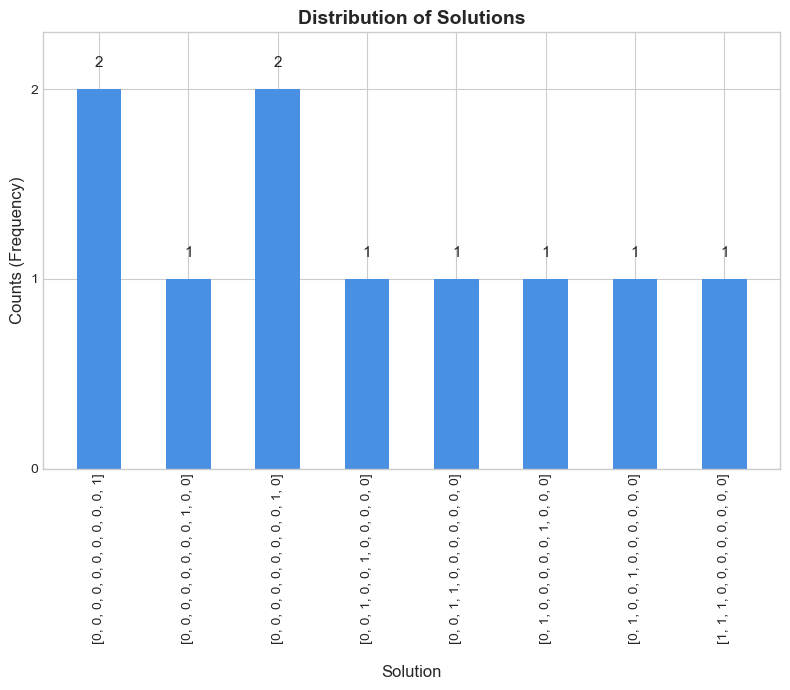

In [16]:
# Plot the distribution of unique solutions
plot_solution_distribution(response)

#### Solving the Problem in Constrained Polynomial Form
We can now define the problem using the `ConstrainedPolynomialModel` class, which will automatically convert the linear constraints into a penalty function and combine them with the original objective. This approach avoids the need to manually construct a QUBO matrix.

To use this model, we provide the objective and constraints separately:

* `coefficients` and `indices`: These define the original linear objective function, $\mathbf{c}^T \mathbf{x}$ . The coefficients variable holds the vector c of costs, while indices specifies the variable for each corresponding coefficient.

* `lhs` and `rhs`: These define the linear equality constraints, $\mathbf{A} \mathbf{x}=\mathbf{b}$. The `lhs` variable is the left-hand-side matrix `A`, and `rhs` is the right-hand-side vector `b`.

In [17]:
coefficients = c
num_vars = 11
indices = [[0, i + 1] for i in range(num_vars)]

lhs = A
rhs = b

# Create the constrained polynomial model
constraint_model = ConstrainedPolynomialModel(coefficients, indices, lhs, rhs)
constraint_model.upper_bound = np.ones(num_vars, ) # Set the upper bound for the variables
# Set the penalty multiplier for the constraints
# This is a crucial step to ensure the constraints are satisfied in the optimization process.
constraint_model.penalty_multiplier = np.sum(np.abs(c)) + 1  # Set the penalty multiplier
print(constraint_model.offset) # Offse term generated by the model

solver = Dirac3IntegerCloudSolver(url=api_url, api_token=api_token)
response = solver.solve(model, num_samples=10)


3
2025-07-14 16:21:24 - Dirac allocation balance = 9645 s (unmetered)
2025-07-14 16:21:25 - Job submitted: job_id='687566c432604586ad908763'
2025-07-14 16:21:25 - QUEUED
2025-07-14 16:21:27 - RUNNING
2025-07-14 16:21:40 - COMPLETED
2025-07-14 16:21:43 - Dirac allocation balance = 9645 s (unmetered)


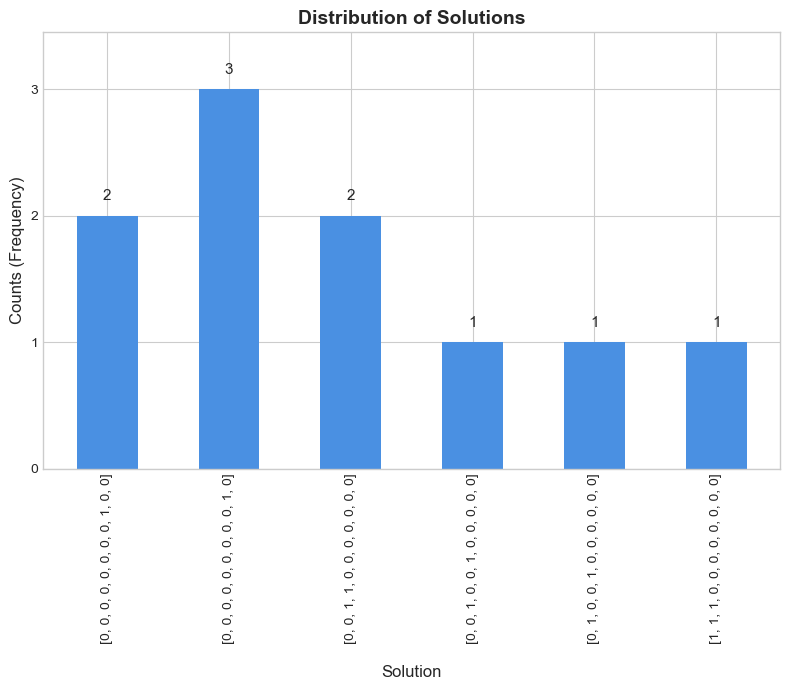

Best Solution: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Best Objective Value: 5


In [18]:
# plot the distribution of unique solutions
plot_solution_distribution(response)

# Extract the best solution and its objective value
best_solution = response["results"]["solutions"][0]
best_objective_value = response["results"]["energies"][0] + constraint_model.offset * constraint_model.penalty_multiplier 
# Add the offset term to get the true objective value

print(f"Best Solution: {best_solution}")
print(f"Best Objective Value: {best_objective_value}")

#### References
* Nguyen, L., et al. (2024). *Entropy Computing: A Paradigm for Optimization in an Open Quantum System*. arXiv preprint arXiv:2407.04512. Retrieved from [https://arxiv.org/abs/2407.04512](https://arxiv.org/abs/2407.04512)

* Quantum Computing Inc. (2024). *Dirac-3 User Guide*. Retrieved from [https://quantumcomputinginc.com/learn/support/user-guides/dirac-3-user-guide](https://assets.ctfassets.net/i1dyhzbyi8ad/55XZTIVzzgNorw3OT6SrLF/af16f0e3148e18928afac9b310e72976/Dirac_3_Users_Guide_v0_02.pdf)